# Data loading: MXNet recordIO

## Overview

This example shows you how to use the data that is stored in the MXNet recordIO format with DALI.

## Creating an Index

To use data that is stored in the recordIO format, we need to use the `MXNetReader` operator. In addition to the arguments that are common to all readers, such as `random_shuffle`, this operator takes the `path` and `index_path` arguments:

* `path` is the list of paths to recordIO files
* `index_path` is a list (of size 1) that contains the path to the index file. This file, with `.idx` extension, is automatically created when you use MXNet's `im2rec.py` utility; and can also be obtained from the recordIO file by using the `rec2idx` utility that is included with DALI.

The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
base = os.path.join(test_data_root, 'db', 'recordio')
batch_size = 16

idx_files = [base + "/train.idx"]
rec_files = [base + "/train.rec"]

## Defining and Running the Pipeline

1. Define a simple pipeline that takes the images that are stored in the recordIO format, decodes them and prepares them for ingestion in DL framework.

   Processing images involves cropping, normalizing, and `HWC` -> `CHW` conversion process.

In [2]:
pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
with pipe:
    jpegs, labels = fn.mxnet_reader(path=rec_files, index_path=idx_files)
    images = fn.image_decoder(jpegs, device="mixed", output_type=types.RGB)
    output = fn.crop_mirror_normalize(
        images,
        dtype=types.FLOAT,
        crop=(224, 224),
        mean=[0., 0., 0.],
        std=[1., 1., 1.])
    pipe.set_outputs(output, labels)

2. Let us now build and run the pipeline:

In [3]:
pipe.build()
pipe_out = pipe.run()

3. To visualize the results, use the `matplotlib` library, which expects images in `HWC` format, but the output of the pipeline is in `CHW`.

   **Note**: `CHW` is the preferred format for most Deep Learning frameworks.
   
4. For the visualization purposes, transpose the images back to the `HWC` layout.

In [4]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        img_chw = image_batch.at(j)
        img_hwc = np.transpose(img_chw, (1,2,0))/255.0
        plt.imshow(img_hwc)

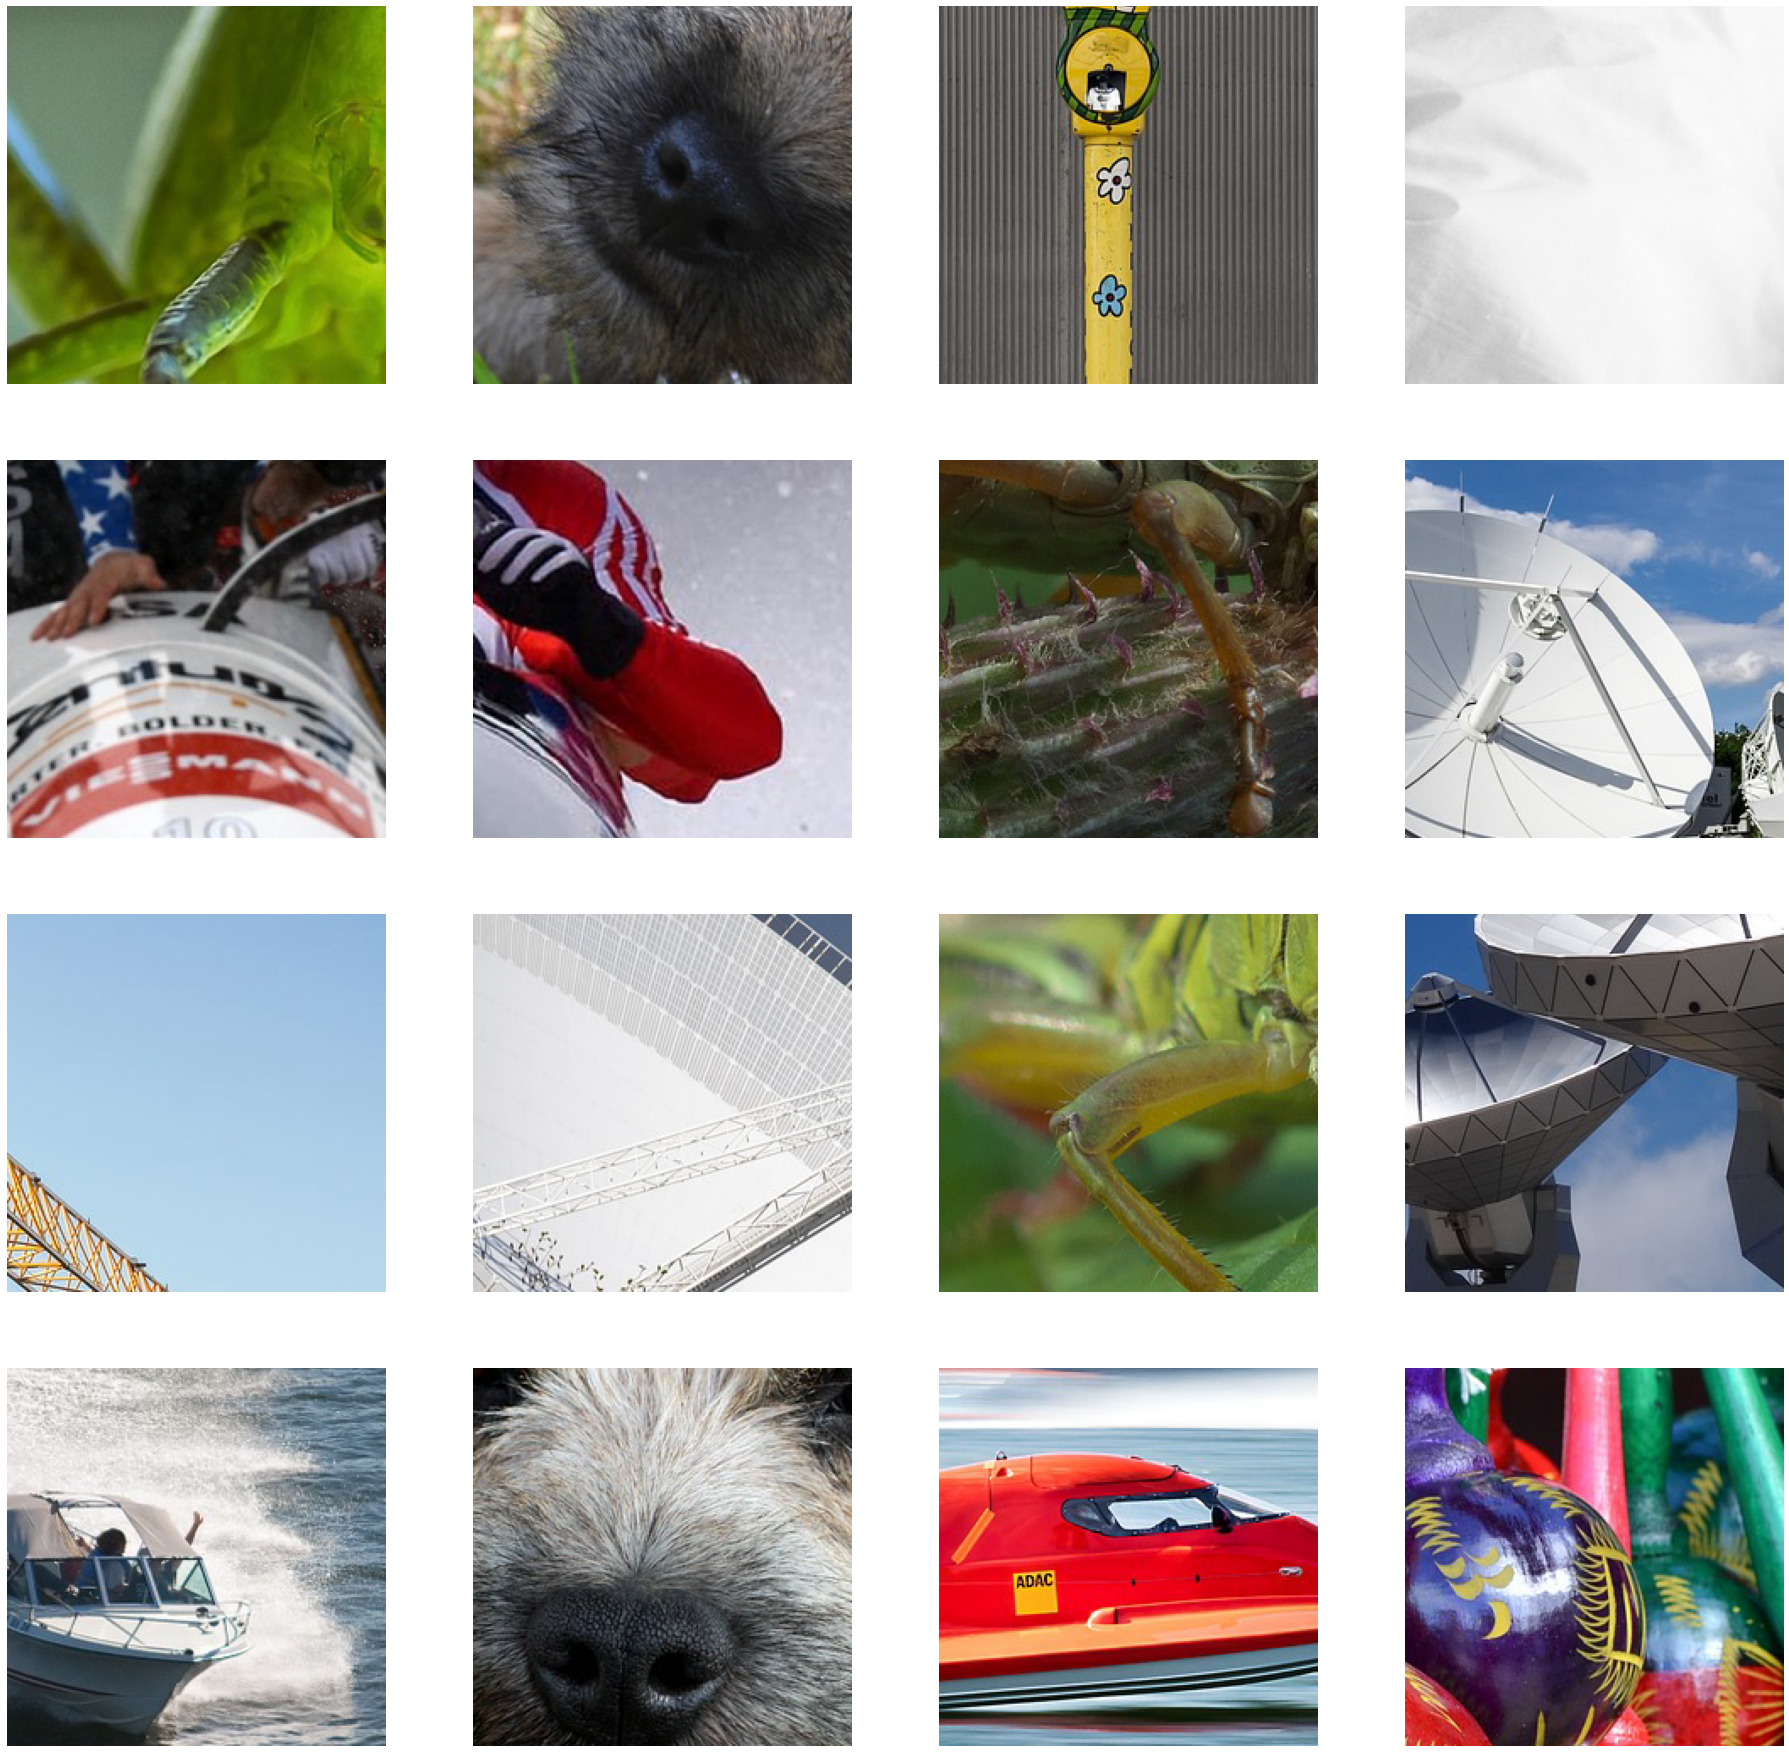

In [5]:
images, labels = pipe_out
show_images(images.as_cpu())